In [61]:
import os
import yaml
os.environ["BASE_DIR"] = "/work/FAC/FGSE/IDYST/tbeucler/downscaling"
BASE_DIR = os.environ["BASE_DIR"]
import json
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [32]:
import torch
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../../Scripts/Functions/Climate_Indices")

Loading the saved quick check trained model from Downscaling_Models/UNet_Deterministic_training_Dataset

In [62]:
model_path = os.path.join(BASE_DIR, "sasthana/Downscaling/Downscaling_Models/models_UNet/UNet_Deterministic_Training_Dataset/best_model_Huber_FULL_RLOP.pth")
training_checkpoint =torch.load(model_path,map_location=torch.device('cpu')) #Moving model to CPU 

In [63]:
#Checking the parameters and keys
print(type(training_checkpoint))

<class 'dict'>


In [64]:
#Checking all model parameters 
for key in training_checkpoint.keys():
    print(key)

epoch
model_state_dict
optimizer_state_dict
loss


In [65]:
#Importing UNet class from Unet.py
sys.path.append(os.path.join(BASE_DIR, "sasthana/Downscaling/Downscaling_Models/models_UNet/UNet_Deterministic_Training_Dataset"))
from UNet import UNet #Importing Unet class
from Downscaling_Dataset_Prep import DownscalingDataset #for creating paired frames

In [66]:
#Creating model instance

In [ ]:
model_instance= UNet(in_channels=5, out_channels=4)
model_instance.load_state_dict(training_checkpoint["model_state_dict"])
model_instance.eval()

In [68]:
#Scaled datasets for test set (2011-2020) :loading

In [69]:
precip_input = xr.open_dataset(os.path.join(BASE_DIR, "sasthana", "Downscaling", "Downscaling_Models", "Training_Chronological_Dataset", "RhiresD_input_test_chronological_scaled.nc"))
temp_input = xr.open_dataset(os.path.join(BASE_DIR, "sasthana", "Downscaling", "Downscaling_Models", "Training_Chronological_Dataset", "TabsD_input_test_chronological_scaled.nc"))
tmin_input= xr.open_dataset(os.path.join(BASE_DIR, "sasthana", "Downscaling", "Downscaling_Models", "Training_Chronological_Dataset", "TminD_input_test_chronological_scaled.nc"))
tmax_input= xr.open_dataset(os.path.join(BASE_DIR, "sasthana", "Downscaling", "Downscaling_Models", "Training_Chronological_Dataset", "TmaxD_input_test_chronological_scaled.nc"))

In [70]:
precip_target = xr.open_dataset(os.path.join(BASE_DIR, "sasthana", "Downscaling", "Downscaling_Models", "Training_Chronological_Dataset", "RhiresD_target_test_chronological_scaled.nc"))
temp_target = xr.open_dataset(os.path.join(BASE_DIR, "sasthana", "Downscaling", "Downscaling_Models", "Training_Chronological_Dataset", "TabsD_target_test_chronological_scaled.nc"))
tmin_target = xr.open_dataset(os.path.join(BASE_DIR, "sasthana", "Downscaling", "Downscaling_Models", "Training_Chronological_Dataset", "TminD_target_test_chronological_scaled.nc"))
tmax_target = xr.open_dataset(os.path.join(BASE_DIR, "sasthana", "Downscaling", "Downscaling_Models", "Training_Chronological_Dataset", "TmaxD_target_test_chronological_scaled.nc"))

In [71]:
#Building the paired feature-target dataset; first loading individual and coverting them into images

In [72]:
# config used for training 
config_path = os.path.join(BASE_DIR, "sasthana/Downscaling/Downscaling_Models/models_UNet/UNet_Deterministic_Training_Dataset/config.yaml")
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)


In [73]:
# elevation
elevation_path = os.path.join(BASE_DIR, "sasthana/Downscaling/Downscaling_Models/elevation.tif")


merging DS before creating pairs,,,,wont work for individual files

In [74]:
inputs_merged = xr.merge([precip_input, temp_input, tmin_input, tmax_input])
targets_merged = xr.merge([precip_target, temp_target, tmin_target, tmax_target])

ds = DownscalingDataset(inputs_merged, targets_merged, config, elevation_path)

Loaded elevation from /work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/elevation.tif, shape: (255, 387)


In [75]:
#Checking shape of the ds instance 
print(f"Dataset shape: {ds.__len__()} samples") #Number of samples in the test set

Dataset shape: 3653 samples


In [76]:
#Checking shape of a random sample
input_img,target_img= ds[15] #14 th sample
print(f"Input image shape: {input_img.shape}")
print(f"Target image shape: {target_img.shape}")

Input image shape: torch.Size([5, 240, 370])
Target image shape: torch.Size([4, 240, 370])


In [77]:
from torch.utils.data import DataLoader

paired_ds = DataLoader(ds, batch_size=1, shuffle=False, num_workers=4)

/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/MyPythonEnvNew/lib/python3.10/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [78]:
for input_batch, target_batch in paired_ds:
    print(input_batch.shape)  # (1, 5, H, W)
    print(target_batch.shape) # (1, 4, H, W)
    break  # iterating once 

torch.Size([1, 5, 240, 370])
torch.Size([1, 4, 240, 370])


In [79]:
idx= 45
input_img, target_img =ds[idx]
input_img= input_img.unsqueeze(0) # Adding batch dimension


In [80]:
model_instance.eval()
with torch.no_grad():
    pred_img = model_instance(input_img).squeeze(0).cpu().numpy()  
target_img = target_img.cpu().numpy()  

In [81]:
def descale_precip(x, min_val, max_val):
    return x * (max_val - min_val) + min_val

def descale_temp(x, mean, std):
    return x * std + mean

In [82]:
# Scaling params loading from the .json files
scaling_dir = os.path.join(BASE_DIR, "sasthana/Downscaling/Downscaling_Models/Training_Chronological_Dataset")
rhiresd_params = json.load(open(os.path.join(scaling_dir, "RhiresD_scaling_params_chronological.json")))
tabsd_params   = json.load(open(os.path.join(scaling_dir, "TabsD_scaling_params_chronological.json")))
tmind_params   = json.load(open(os.path.join(scaling_dir, "TminD_scaling_params_chronological.json")))
tmaxd_params   = json.load(open(os.path.join(scaling_dir, "TmaxD_scaling_params_chronological.json")))

In [83]:
pred_img_denorm = np.empty_like(pred_img)
target_img_denorm = np.empty_like(target_img)

pred_img_denorm[0] = descale_precip(pred_img[0], rhiresd_params["min"], rhiresd_params["max"])
pred_img_denorm[1] = descale_temp(pred_img[1], tabsd_params["mean"], tabsd_params["std"])
pred_img_denorm[2] = descale_temp(pred_img[2], tmind_params["mean"], tmind_params["std"])
pred_img_denorm[3] = descale_temp(pred_img[3], tmaxd_params["mean"], tmaxd_params["std"])

target_img_denorm[0] = descale_precip(target_img[0], rhiresd_params["min"], rhiresd_params["max"])
target_img_denorm[1] = descale_temp(target_img[1], tabsd_params["mean"], tabsd_params["std"])
target_img_denorm[2] = descale_temp(target_img[2], tmind_params["mean"], tmind_params["std"])
target_img_denorm[3] = descale_temp(target_img[3], tmaxd_params["mean"], tmaxd_params["std"])

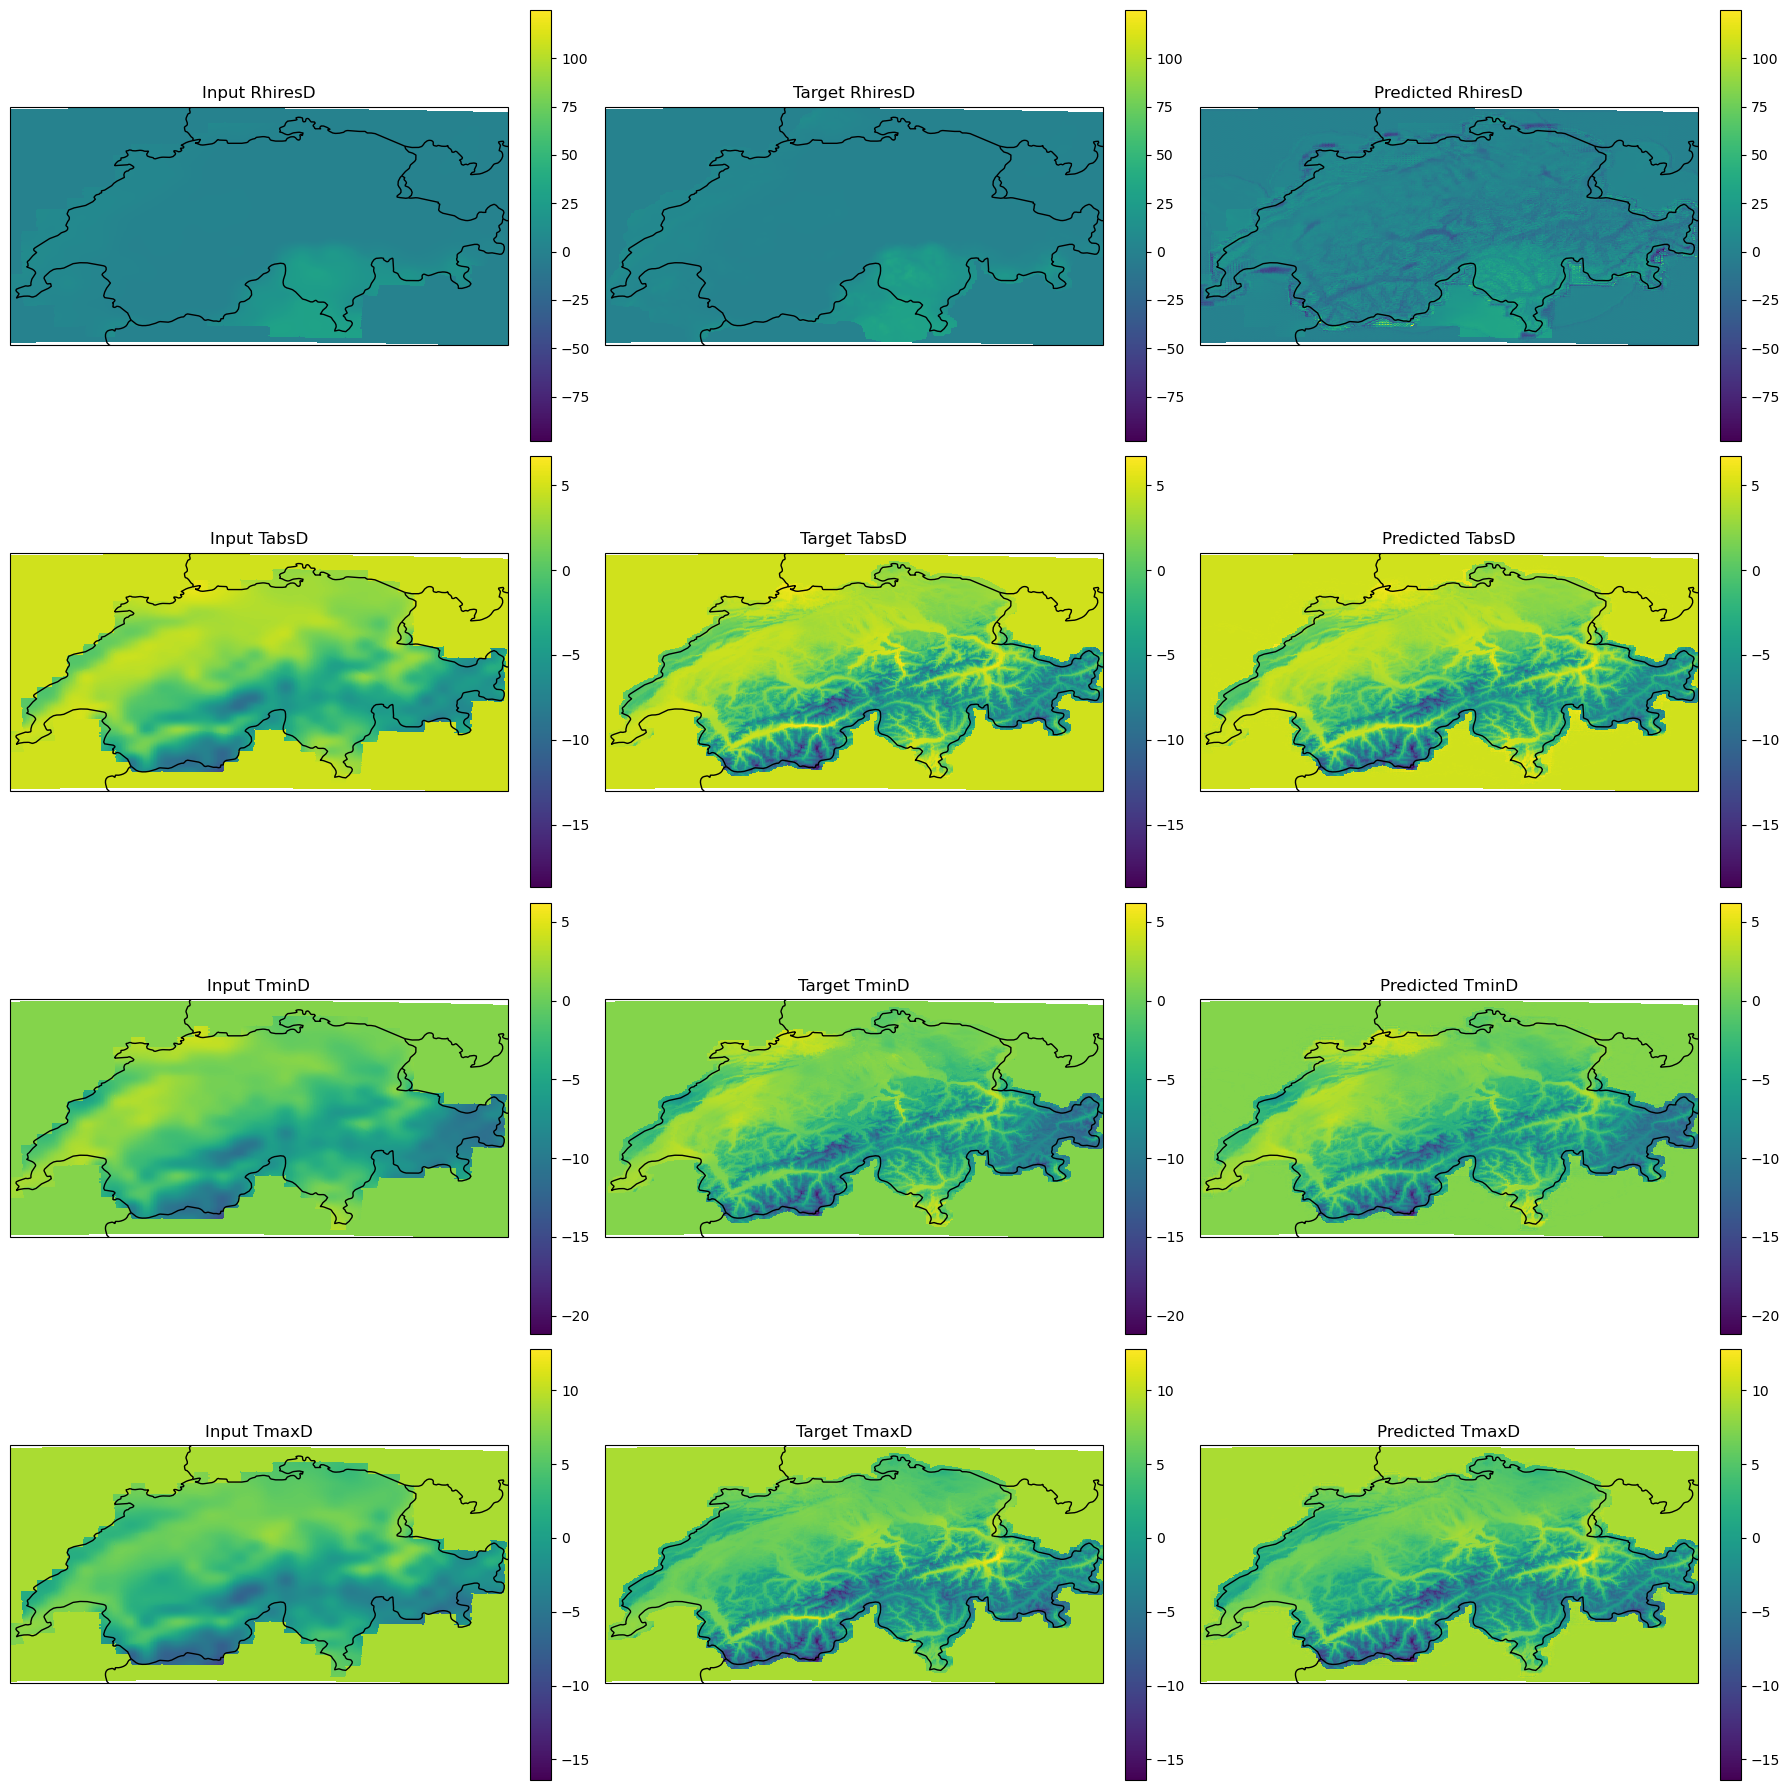

In [86]:
lat = inputs_merged.lat.values
lon = inputs_merged.lon.values
var_names = ["RhiresD", "TabsD", "TminD", "TmaxD"]

swiss_extent = [5.9, 10.5, 45.7, 47.9]  

fig, axes = plt.subplots(4, 3, figsize=(18, 18), subplot_kw={'projection': ccrs.PlateCarree()})
input_img = input_img.squeeze(0)  
for i, var in enumerate(var_names):
    # Get input image for this variable (input_img shape: (5, H, W))
    input_img_denorm = None
    if var == "RhiresD":
        input_img_denorm = descale_precip(input_img[0].cpu().numpy(), rhiresd_params["min"], rhiresd_params["max"])
    elif var == "TabsD":
        input_img_denorm = descale_temp(input_img[1].cpu().numpy(), tabsd_params["mean"], tabsd_params["std"])
    elif var == "TminD":
        input_img_denorm = descale_temp(input_img[2].cpu().numpy(), tmind_params["mean"], tmind_params["std"])
    elif var == "TmaxD":
        input_img_denorm = descale_temp(input_img[3].cpu().numpy(), tmaxd_params["mean"], tmaxd_params["std"])

    vmin = min(target_img_denorm[i].min(), pred_img_denorm[i].min(), input_img_denorm.min())
    vmax = max(target_img_denorm[i].max(), pred_img_denorm[i].max(), input_img_denorm.max())

    # Input
    ax = axes[i, 0]
    im = ax.pcolormesh(lon, lat, input_img_denorm, cmap='viridis', vmin=vmin, vmax=vmax, shading='auto', transform=ccrs.PlateCarree())
    ax.set_title(f"Input {var}")
    ax.set_extent(swiss_extent, crs=ccrs.PlateCarree())
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.BORDERS)
    fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

    # Target
    ax = axes[i, 1]
    im = ax.pcolormesh(lon, lat, target_img_denorm[i], cmap='viridis', vmin=vmin, vmax=vmax, shading='auto', transform=ccrs.PlateCarree())
    ax.set_title(f"Target {var}")
    ax.set_extent(swiss_extent, crs=ccrs.PlateCarree())
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.BORDERS)
    fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

    # Predicted
    ax = axes[i, 2]
    im = ax.pcolormesh(lon, lat, pred_img_denorm[i], cmap='viridis', vmin=vmin, vmax=vmax, shading='auto', transform=ccrs.PlateCarree())
    ax.set_title(f"Predicted {var}")
    ax.set_extent(swiss_extent, crs=ccrs.PlateCarree())
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.BORDERS)
    fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()